# Coordinate conversion

In this example, we will load an archival all-sky Galactic reddening map, E(B-V),
based on the derived reddening maps of Schlegel, Finkbeiner and Davis (1998).
It has been translated into an HEALPix map in galactic coordinates by the Legacy Archive
for Microwave Background Data Analysis [LAMBDA](http://lambda.gsfc.nasa.gov/).
We'll rotate it into equatorial coordinates for demonstration purpose.

## Algorithm

It follows the following reasoning:

- get the coordinates of the centers of the HEALPix map in galactic coordinates,
- converts those to equatorial coordinates with the astropy library,
- find the bilinear interpolation for the neighbors of each of these new coordinates using cdshealpix methods,
- apply it to form a HEALPix map in the new coordinate system.

## Disclaimer

This example was designed to illustrate the use of this library.
This transformation is not the most precise you could get and should be used
for visualizations or to have a quick view at maps in different coordinate systems.
For scientific use, please have a look at the method rotate_alm in
[healpy](https://github.com/healpy/healpy) or at the sht module of the
[ducc](https://gitlab.mpcdf.mpg.de/mtr/ducc) library that both implement the rotation in the spherical harmonics space.

In [19]:
import cdshealpix

from mocpy import MOC, WCS
import astropy.units as u

from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle

import matplotlib.pyplot as plt
import numpy as np

## Fetching the HEALPix map from NASA archives

In [20]:
ext_map = fits.open(
    "https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/" + "lambda_sfd_ebv.fits"
)  # dowloading the map from the nasa archive
hdr = ext_map[0].header  # extracts the header
data_header = ext_map[1].header
data = ext_map[1].data  # extracts the data
ext_map.close()

hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2003-02-05T00:00:00' /file creation date (YYYY-MM-DDThh:mm:ss UT)    
OBJECT  = 'ALL-SKY '           / Portion of sky given                           
COMMENT   This file contains an all-sky Galactic reddening map, E(B-V), based on
COMMENT   the derived reddening maps of Schlegel, Finkbeiner and Davis (1998).  
COMMENT   Software and data files downloaded from their website were used to    
COMMENT   interpolate their high resolution dust maps onto pixel centers        
COMMENT   appropriate for a 

Let's also have a look at the data header

In [21]:
data_header

XTENSION= 'BINTABLE'           /binary table extension                          
BITPIX  =                    8 /8-bit bytes                                     
NAXIS   =                    2 /2-dimensional binary table                      
NAXIS1  =                    8 /width of table in bytes                         
NAXIS2  =              3145728 /number of rows in table                         
PCOUNT  =                    0 /size of special data area                       
GCOUNT  =                    1 /one data group (required keyword)               
TFIELDS =                    2 /number of fields in each row                    
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

After learning that the magnitudes are stored in ``'TEMPERATURE'``, we can extract all useful information.

In [22]:
extinction_values = data["TEMPERATURE"]
nside = hdr["NSIDE"]
norder = hdr["RESOLUTN"]

## Coordinate conversion

We first create an HEALPix grid at order 9 (like the original) in nested ordering

In [23]:
healpix_index = np.arange(12 * 4**norder, dtype=np.uint64)
print(
    f"We can check that the NPIX value corresponds to the one in the header here: {len(healpix_index)}"
)

We can check that the NPIX value corresponds to the one in the header here: 3145728


Then, we get the coordinates of the centers of these healpix cells

In [24]:
center_coordinates_in_equatorial = cdshealpix.healpix_to_skycoord(
    healpix_index, depth=norder
)  # this function works for nested maps, see cdshealpix documentation
center_coordinates_in_equatorial

<SkyCoord (ICRS): (ra, dec) in deg
    [( 45.        ,  0.0746039 ), ( 45.08789062,  0.14920793),
     ( 44.91210938,  0.14920793), ..., (315.08789062, -0.14920793),
     (314.91210938, -0.14920793), (315.        , -0.0746039 )]>

Conversion into galactic coordinates with astropy method

In [25]:
center_coordinates_in_galactic = center_coordinates_in_equatorial.galactic
center_coordinates_in_galactic

<SkyCoord (Galactic): (l, b) in deg
    [(176.8796283 , -48.85086427), (176.89078038, -48.7358142 ),
     (176.70525363, -48.86216423), ..., ( 48.82487228, -28.4122831 ),
     ( 48.7216889 , -28.26178141), ( 48.84578935, -28.29847774)]>

Calculate the bilinear interpolation that must be applied to each
HEALPix cell to obtain the magnitude values in the other coordinate system.

In [26]:
healpix, weights = cdshealpix.bilinear_interpolation(
    center_coordinates_in_galactic.l, center_coordinates_in_galactic.b, depth=norder
)
# then apply the interpolation
ext_map_equatorial_nested = (extinction_values[healpix.data] * weights.data).sum(axis=1)

## Convert the two HEALPix into MOCs for visualization

We produce the extinction MOCs by excluding the high extinction regions. This allows to have a clear view of the position
of the galactic disc.

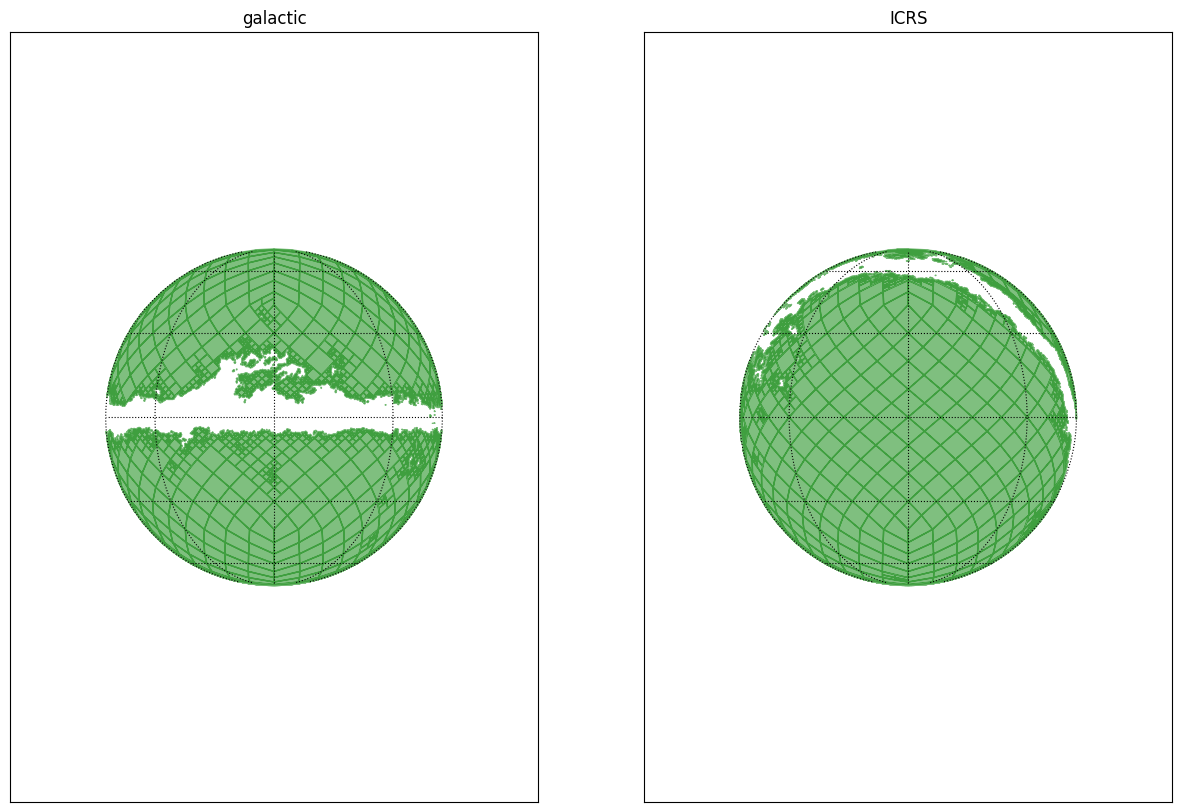

In [27]:
# For the HEALPix in equatorial coordinate system
low_extinction_index_equatorial = np.where(ext_map_equatorial_nested < 0.5)[0]
moc_low_extinction_equatorial = MOC.from_healpix_cells(
    ipix=low_extinction_index_equatorial,
    depth=np.full((len(low_extinction_index_equatorial)), norder),
    max_depth=norder,
)

# For the HEALPix in galactic coordinate system
low_extinction_index_galactic = np.where(extinction_values < 0.5)[0]
moc_low_extinction_galactic = MOC.from_healpix_cells(
    ipix=low_extinction_index_galactic,
    depth=np.full((len(low_extinction_index_galactic)), norder),
    max_depth=norder,
)

# Plot the MOCs using matplotlib
fig = plt.figure(figsize=(15, 10))
# Define a astropy WCS from the mocpy.WCS class
with WCS(
    fig,
    fov=120 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="SIN",
) as wcs:
    ax1 = fig.add_subplot(121, projection=wcs, aspect="equal", adjustable="datalim")
    ax2 = fig.add_subplot(122, projection=wcs, aspect="equal", adjustable="datalim")
    moc_low_extinction_galactic.fill(
        ax=ax1, wcs=wcs, alpha=0.5, fill=True, color="green"
    )
    moc_low_extinction_equatorial.fill(
        ax=ax2, wcs=wcs, alpha=0.5, fill=True, color="green"
    )

ax1.set(xlabel="l", ylabel="b", title="galactic")
ax2.set(xlabel="ra", ylabel="dec", title="ICRS")

ax1.grid(color="black", linestyle="dotted")
ax2.grid(color="black", linestyle="dotted")
plt.show()